In [3]:
import os, shutil
import pathlib
import random
import IPython.display as display
from sklearn.model_selection import train_test_split

data_root = pathlib.Path('data/flower_photos/')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

#  打乱数据顺序
random.shuffle(all_image_paths) 

print(len(all_image_paths))  # 3670
print(all_image_paths[:5])


# all_image_paths是包含所有图像文件路径的数组
all_image_labels = [pathlib.Path(path).parent.name for path in all_image_paths]

data\flower_photos\daisy
data\flower_photos\dandelion
data\flower_photos\LICENSE.txt
data\flower_photos\roses
data\flower_photos\sunflowers
data\flower_photos\tulips
3670
['data\\flower_photos\\tulips\\470690620_9d3a5bb239.jpg', 'data\\flower_photos\\sunflowers\\8929213942_5544191250_n.jpg', 'data\\flower_photos\\sunflowers\\19453165201_2aa747e0bf.jpg', 'data\\flower_photos\\sunflowers\\14925398301_55a180f919_n.jpg', 'data\\flower_photos\\tulips\\15029962436_3e50c1f30f_n.jpg']


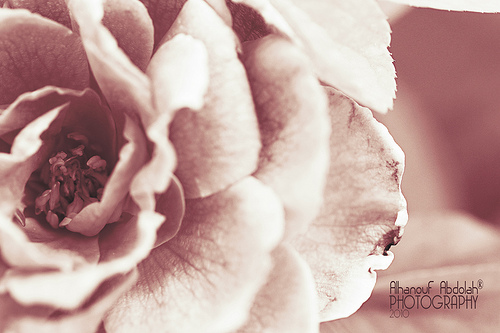

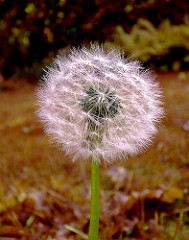

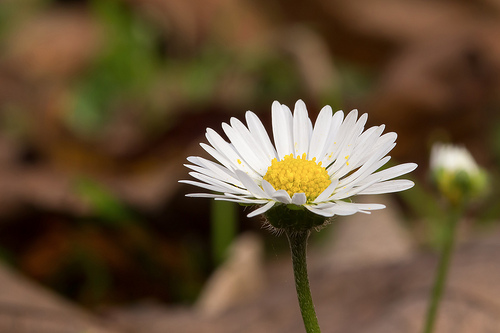

In [4]:
# 上述代码我们得到了全部图像的路径，包含3670张图像。随机浏览其中3张图像方法很简单，先随机读取一张图像的路径，再使用display（）函数展示
for i in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))

In [5]:
# 使用 train_test_split 方法拆分数据集
train_x, valid_x, train_y, valid_y = train_test_split(all_image_paths,
                                                      all_image_labels,
                                                      train_size = 0.8,
                                                      random_state = 104)

def crate_sub_dataset(images, labels, dataset_path):
    for index, image_path in enumerate(images):
        image_label = labels[index]

        # 创建标签数据集目录
        target_dir = os.path.join(dataset_path, image_label)
        pathlib.Path(target_dir).mkdir(parents=True, exist_ok=True)

        # 复制图像文件到目标文件夹
        target_path = os.path.join(target_dir, pathlib.Path(image_path).name)
        shutil.copyfile(image_path, target_path)
    return dataset_path

# 删除已存在文件
shutil.rmtree('data/flower-set/train', ignore_errors=True)
shutil.rmtree('data/flower-set/valid', ignore_errors=True)

train_dataset_path = crate_sub_dataset(train_x, train_y, 'data/flower-set/train')
valid_dataset_path = crate_sub_dataset(valid_x, valid_y, 'data/flower-set/valid')

In [6]:
# 数据集预处理
# （1）读取图像文件
# （2）将文件解码为RGB像素网格
# （3）将这些像素网格转换为浮点型张量
# （4）将数据归一化，把像素值0~255缩放到【0,1】
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 创建两个生成器，rescale属性表示将图像张量乘以1/255来进行归一化
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# 使用生成器，读取目录中的图像
train_generator = train_datagen.flow_from_directory(
    directory = train_dataset_path,   # 数据读取的目录
    target_size = (192, 192),    # 张量尺寸，所有图像将缩减至指定尺寸
    batch_size = 100   # 批次大小
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dataset_path,
    target_size=(192, 192),
    batch_size=100
)


Found 2936 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


In [7]:
# 创建的两个生成器，迭代任意一个生成器时，每次返回一个[100, 192, 192, 3]的形状的张量和一个[100, 5]形状的张量。
# 第一个张量为输入特征，表示100个形状为[192， 192， 3]的样本；第二个张量为输出标签，表示100个样本的五分类One-hot标签。
# 需要注意的是，两个生成器时无限循环生成器，会循环目标文件夹中的图像。因此需要在恰当的时机用break终止循环

for data_batch, label_batch in train_generator:
    print(f"data_batch shape:{data_batch.shape}")
    print(f"label_batch shape:{label_batch.shape}")
    break

# data_batch shape: [100, 192, 192, 3]
# label_batch shape: [100, 5]

data_batch shape:(100, 192, 192, 3)
label_batch shape:(100, 5)


In [8]:
# 简单的卷积神经网络
# 在预处理两个图像数据处理器后，我们用两个生成器来训练模型。用生成器训练模型需要使用fit_generator（）方法
# fit_generator（）方法的第一个参数是一个训练数据生成器，可以不停的生成输入特征和输出标签组成的批次（batch）。
# 因为训练数据生成器不断产生，需要制定steps_per_epoch参数来表示每一轮中需要从训练数据生成器中取出多少个批次。
# 在使用fit_generator()时，还可以传入一个validation_data参数，其作用和在fit方法中类似。该参数既可以输入一个验证数据生成器，又可以输入Numpy数组组成的元组。
# 如果validation_data传入的是验证数据生成器，那么也需要指定validation_steps参数
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

plt.rcParams['figure.dpi'] = 180

L = keras.layers

base_model = keras.Sequential([
    L.Conv2D(input_shape=(192, 192, 3), filters=32, kernel_size=5, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Conv2D(filters=64, kernel_size=3, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Flatten(),
    L.Dense(64, activation=tf.nn.relu),
    L.Dense(5, activation=tf.nn.softmax)
    ])

base_model.compile(optimizer=tf.optimizers.RMSprop(),
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
base_model.summary()


# 使用fit_generator()方法训练模型
history = base_model.fit_generator(
    train_generator,                    # 训练数据生成器
    steps_per_epoch=30,                 # 训练批次
    epochs=50,                          # 总共的训练轮数
    validation_data=valid_generator,    # 验证数据生成器
    validation_steps=8                  # 验证批次
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 188, 188, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 94, 94, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 135424)            0         
                                                                 
 dense (Dense)               (None, 64)                8

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12396\3254968776.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = base_model.fit_generator(


Epoch 1/50
30/30 [==============================] - 61s 2s/step - loss: 9.0552 - accuracy: 0.2980 - val_loss: 1.5021 - val_accuracy: 0.3678
Epoch 2/50
30/30 [==============================] - 48s 2s/step - loss: 1.5201 - accuracy: 0.3675 - val_loss: 1.3909 - val_accuracy: 0.4346
Epoch 3/50
30/30 [==============================] - 53s 2s/step - loss: 1.4367 - accuracy: 0.4169 - val_loss: 1.3625 - val_accuracy: 0.4496
Epoch 4/50
30/30 [==============================] - 49s 2s/step - loss: 1.6682 - accuracy: 0.3239 - val_loss: 1.5502 - val_accuracy: 0.2984
Epoch 5/50
30/30 [==============================] - 47s 2s/step - loss: 1.5899 - accuracy: 0.3808 - val_loss: 1.5450 - val_accuracy: 0.3692
Epoch 6/50
30/30 [==============================] - 48s 2s/step - loss: 1.5009 - accuracy: 0.4189 - val_loss: 1.5082 - val_accuracy: 0.3978
Epoch 7/50
30/30 [==============================] - 49s 2s/step - loss: 1.3783 - accuracy: 0.4486 - val_loss: 1.4587 - val_accuracy: 0.3856
Epoch 8/50
30/30 [==

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12396\1972057453.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


<Figure size 1152x864 with 0 Axes>

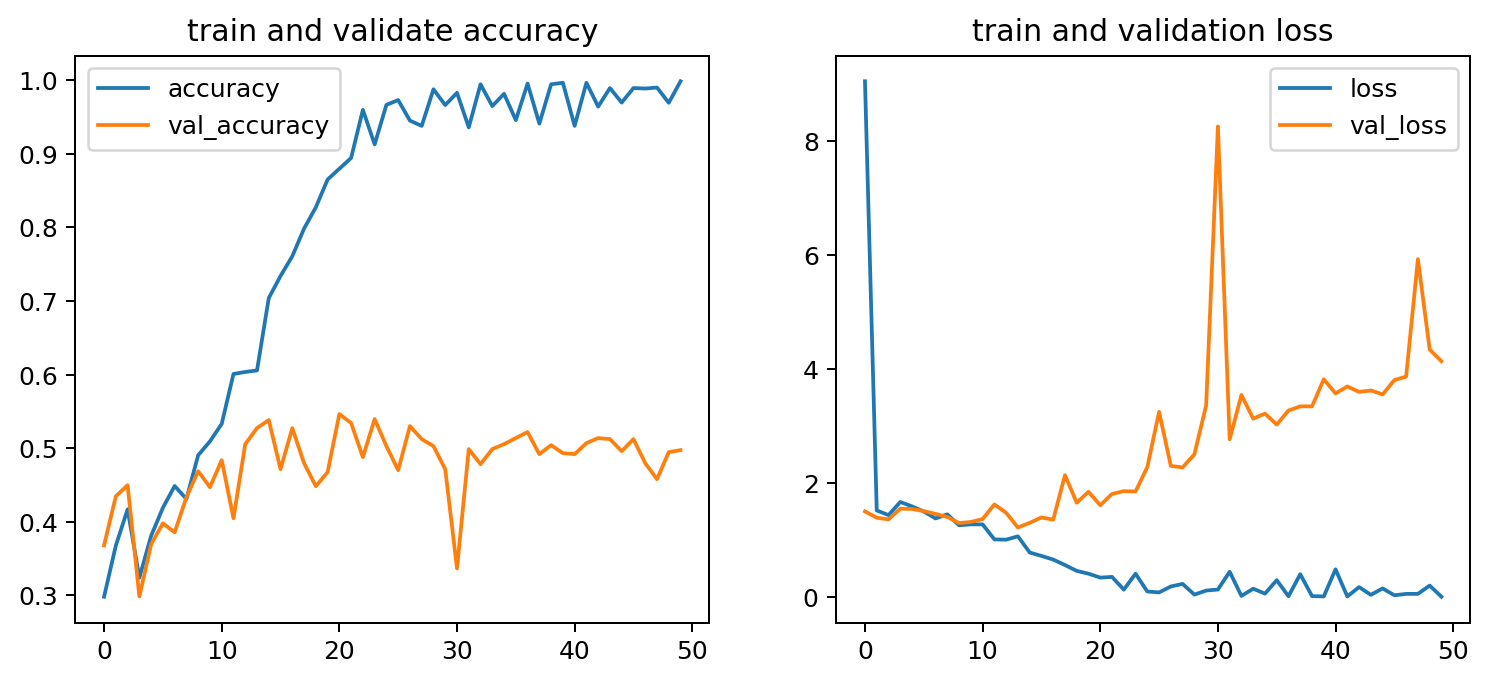

In [11]:
# Matplotlib展示模型在训练过程中的准确率和损失
def visualize_keras_history(history):
    plt.figure()   
    # 设置子图大小
    plt.subplots(figsize=(10, 9))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('train and validate accuracy')   #  添加图形标题

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('train and validation loss')  

    plt.show()

visualize_keras_history(history)

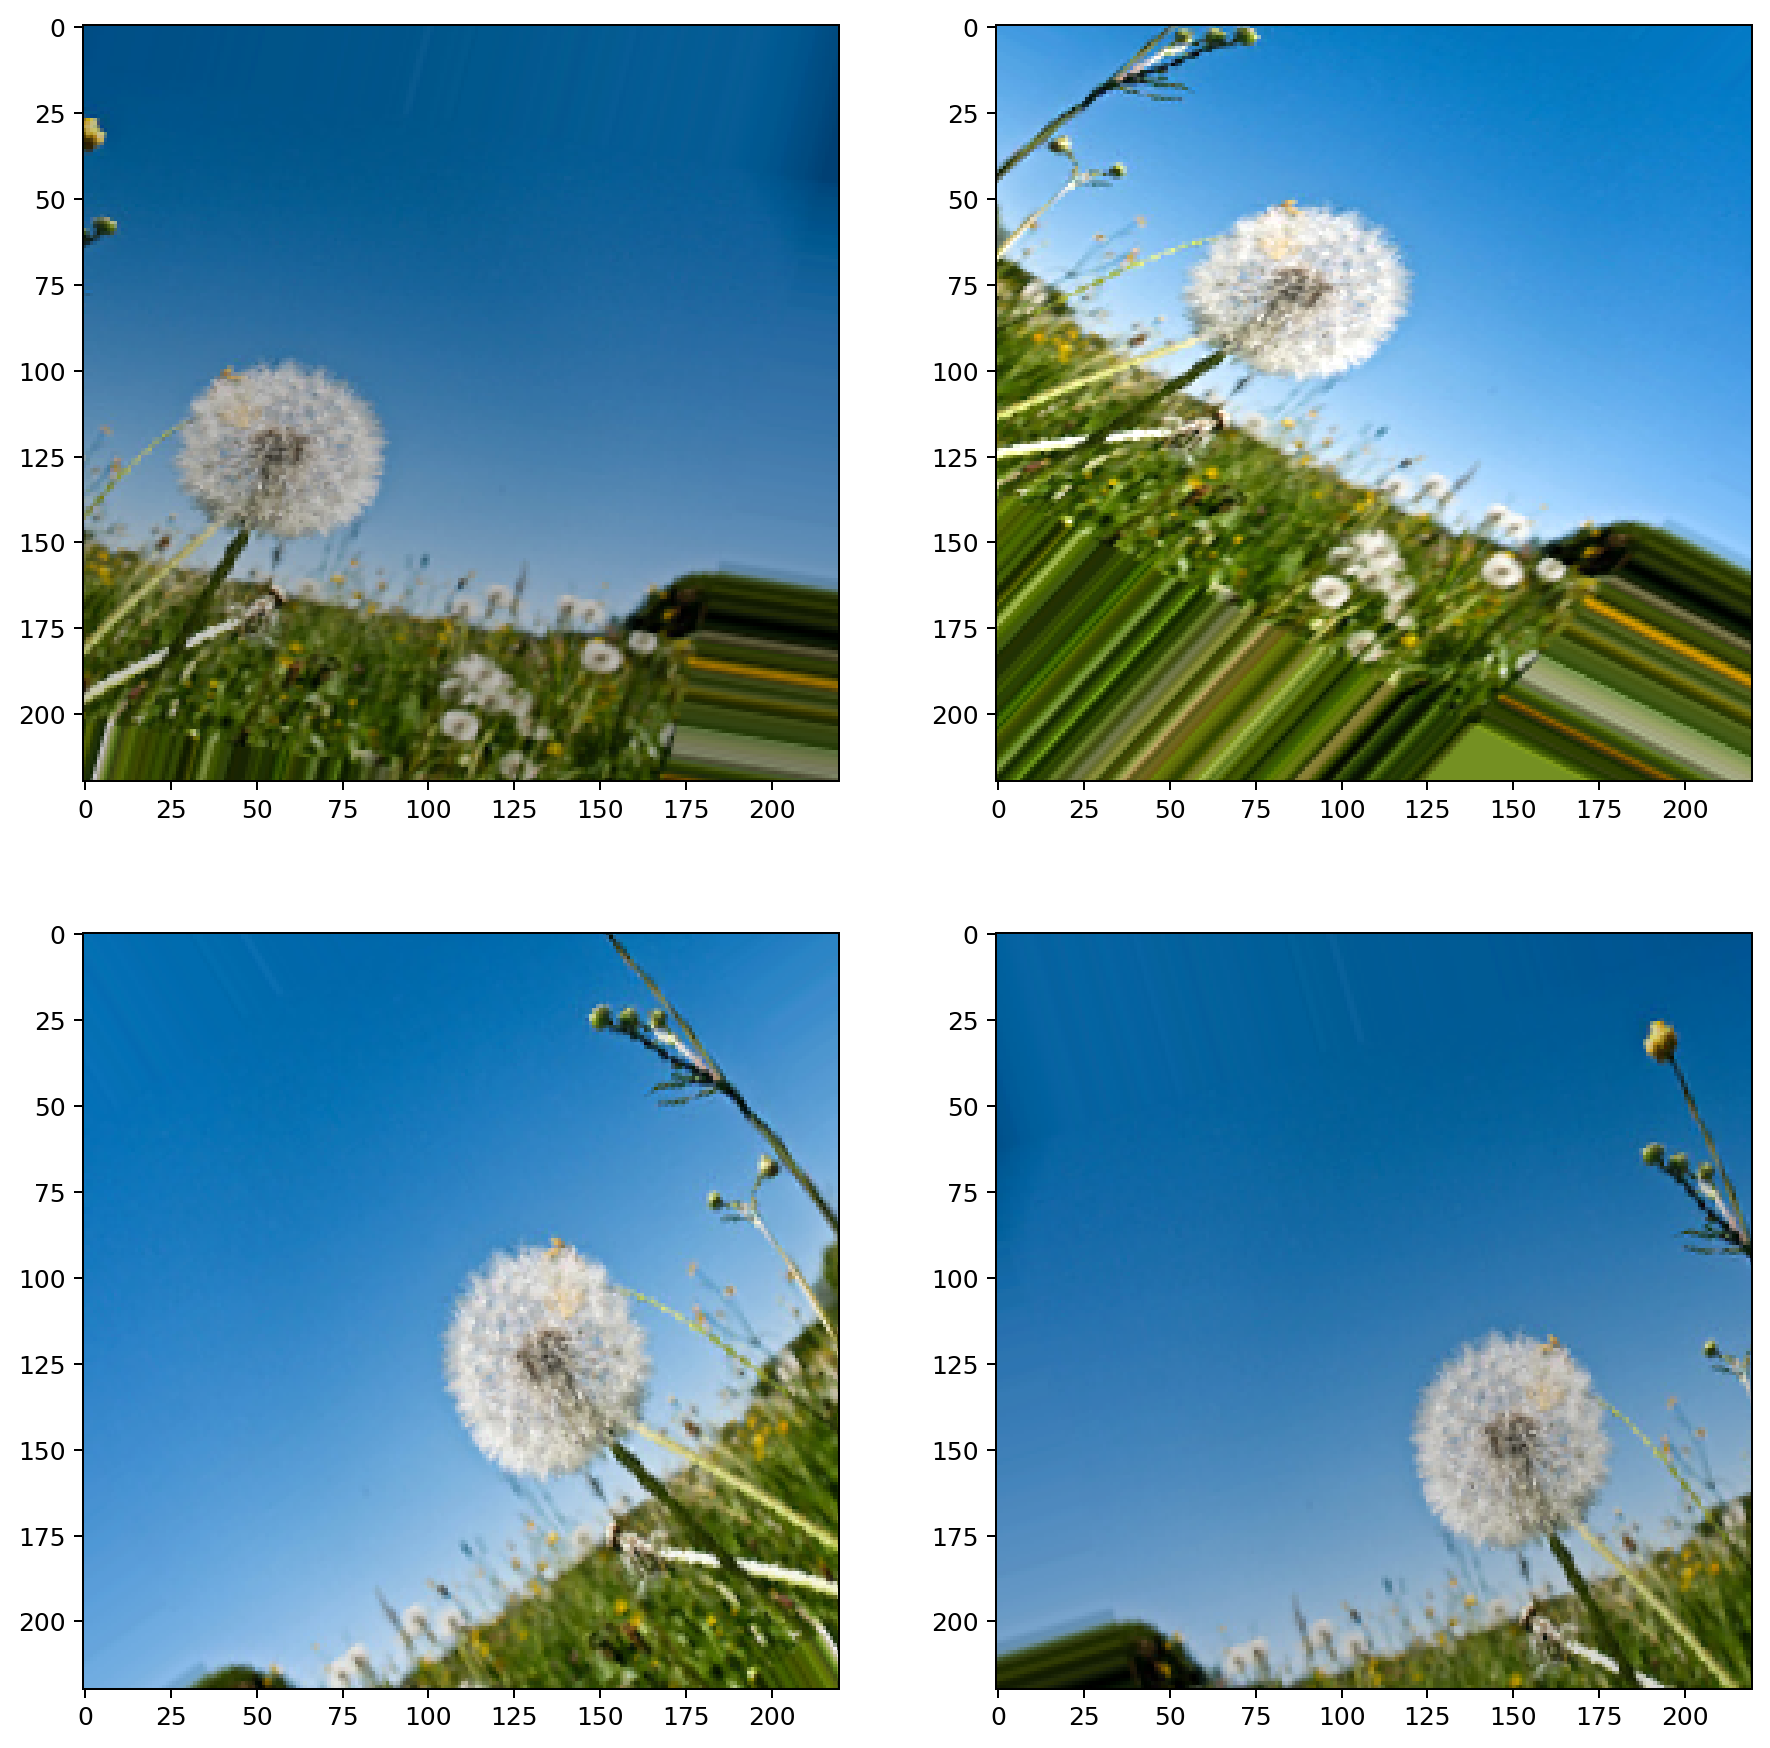

In [12]:
# 分析上图发现，经过100轮训练后，验证准确率不在上升，保持在55%左右。训练损失持续下降到0，验证损失在10轮训练后不再下降。--出现了过拟合
# 解决过拟合问题的方法：Dropout和权重正则化。但是计算机视觉领域还有另一种方法，使用数据增强（深度学习模型处理图像时）

# 使用ImageDataGenerator类读取图像并进行多次随机变换
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# 读取表示某一图像的张量
img_path = './data/flower_photos/dandelion/5909154147_9da14d1730_n.jpg'
img = load_img(img_path, target_size=(220, 220))  #  读取图像
x = img_to_array(img)                             #  将图像转换为Numpy数组
x = x.reshape((1,) + x.shape)                     #  将图像形状改为（1， 220， 220， 3）


# 初始化图像生成器
random_data_gen = ImageDataGenerator(
    rescale = 1./255,                # 归一化
    rotation_range = 40,             # 图像旋转的范围
    width_shift_range = 0.2,         # 图像水平平移的范围（相对宽度的比例）
    height_shift_range = 0.2,        # 图像垂直平移的范围（相对宽度的比例）
    shear_range = 0.2,               # 图像错切变换的角度范围
    zoom_range = 0.2,                # 图像缩放的范围
    brightness_range = (0.6, 1.2),   # 图像亮度调整的范围
    horizontal_flip = True           # 是否随机水平翻转
)

# 生成随机变换后的批次。由于循环是无限的，所以需要break来打断
i = 0
plt.figure(figsize=(12, 12))
# random_data_gen_flow()方法使用给定的文件路径数组初始化一个生成器
for batch in random_data_gen.flow(x, batch_size=1):
    plt.subplot(2, 2, i+1)
    plt.imshow(batch[0])
    plt.grid(False)


    i = i + 1
    if i == 4:
        break

plt.show()

In [13]:
# 现在使用增强后的数据再次训练简单的卷积神经网络。在进行数据增强后，模型中不再会多次使用同样的输入进行训练
random_data_gen = ImageDataGenerator(
    rescale = 1./255,                                 # 归一化
    rotation_range = 40,                              # 图像旋转的范围
    width_shift_range = 0.2,                          # 图像水平平移的范围（相对宽度的比例）
    height_shift_range = 0.2,                         # 图像垂直平移的范围（相对宽度的比例）
    shear_range = 0.2,                                # 图像错切变换的角度范围
    zoom_range = 0.2,                                 # 图像缩放的范围
    brightness_range=(0.6, 1.2),                      # 图像亮度调整范围
    horizontal_flip = True                            # 是否随机水平旋转
)


# 不能增强验证集数据
valid_data_gen = ImageDataGenerator(rescale=1./255)

train_aug_gen = random_data_gen.flow_from_directory(
    train_dataset_path,
    target_size = (192, 192), 
    batch_size = 100,
    class_mode = 'categorical'
)

valid_aug_gen = valid_data_gen.flow_from_directory(
    valid_dataset_path,
    target_size=(192, 192),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

# 再次使用同样的模型，以便效果进行对比
aug_model = keras.Sequential([
    L.Conv2D(input_shape=(192, 192, 3), filters=32, kernel_size=5, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Conv2D(filters=64, kernel_size=3, strides=1),
    L.MaxPool2D(pool_size=2, strides=2),
    L.Flatten(),
    L.Dense(128, activation=tf.nn.relu),
    L.Dense(5, activation=tf.nn.softmax)
])


aug_model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4),
                   loss=tf.losses.CategoricalCrossentropy(),
                   metrics=['accuracy'])


aug_model.summary()


# 由于这个模型不会出现过拟合，所以我们训练 100 轮来获得的更好的结果
aug_history = aug_model.fit_generator(
      train_aug_gen,                   # 训练批次生成器
      steps_per_epoch=30,              # 训练批次数量
      epochs=100,                      # 总共训练轮数
      validation_data=valid_aug_gen,   # 验证批次生成器
      validation_steps=8,              # 验证批次数量
)


Found 2936 images belonging to 5 classes.
Found 734 images belonging to 5 classes.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 188, 188, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 94, 94, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 135424)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12396\2778455731.py:53: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  aug_history = aug_model.fit_generator(


Epoch 1/100
30/30 [==============================] - 65s 2s/step - loss: 3.3741 - accuracy: 0.3164 - val_loss: 1.2616 - val_accuracy: 0.4796
Epoch 2/100
30/30 [==============================] - 60s 2s/step - loss: 1.3230 - accuracy: 0.4370 - val_loss: 1.2187 - val_accuracy: 0.4959
Epoch 3/100
30/30 [==============================] - 62s 2s/step - loss: 1.2576 - accuracy: 0.4697 - val_loss: 1.1744 - val_accuracy: 0.5082
Epoch 4/100
30/30 [==============================] - 64s 2s/step - loss: 1.2516 - accuracy: 0.4782 - val_loss: 1.1586 - val_accuracy: 0.5204
Epoch 5/100
30/30 [==============================] - 60s 2s/step - loss: 1.2184 - accuracy: 0.4983 - val_loss: 1.2313 - val_accuracy: 0.4959
Epoch 6/100
30/30 [==============================] - 61s 2s/step - loss: 1.2181 - accuracy: 0.4918 - val_loss: 1.1397 - val_accuracy: 0.5245
Epoch 7/100
30/30 [==============================] - 60s 2s/step - loss: 1.1886 - accuracy: 0.5163 - val_loss: 1.1330 - val_accuracy: 0.5450
Epoch 8/100
3